In [10]:
import sys, os

# Point to project root (one level above /notebooks)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, project_root)

print("Project root added to PYTHONPATH:", project_root)


Project root added to PYTHONPATH: /home/jasnoorpannu/CSE/Projects/dropout-predictor


In [11]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve, RocCurveDisplay
from src.config import MODEL_PATH, RAW_DATA
from src.preprocessing import load_raw, prepare_features
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from src.config import RAW_DATA, MODEL_PATH
from src.preprocessing import load_raw, prepare_features

In [12]:
raw = load_raw(RAW_DATA)
df = prepare_features(raw, cutoff=60)
X = df.drop(["id_student", "dropout"], axis=1)
y = df["dropout"]
model = joblib.load(MODEL_PATH)
preds = model.predict(X)

Extracting Static Features...
Extracting Dynamic Features (Cutoff: 60)...
    -> Filtering data: Keeping only days <= 60
Merging...


In [18]:
auc = roc_auc_score(y, preds)
ap = average_precision_score(y, preds)
binary_preds = (preds >= 0.5).astype(int)

precision = precision_score(y, binary_preds)
recall = recall_score(y, binary_preds)
f1 = f1_score(y, binary_preds)

print("AUC: ", auc)
print("Average Precision: ", ap)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

AUC:  0.8566453591034621
Average Precision:  0.7786289085679574
Precision:  0.6829796448679082
Recall:  0.6975561207563862
F1 Score:  0.6901909294819192


              precision    recall  f1-score   support

           0       0.86      0.85      0.86     19742
           1       0.68      0.70      0.69      9043

    accuracy                           0.80     28785
   macro avg       0.77      0.77      0.77     28785
weighted avg       0.80      0.80      0.80     28785



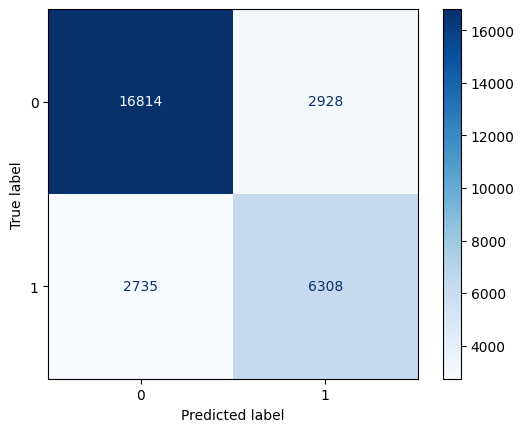

In [14]:
print(classification_report(y, binary_preds))
cm = confusion_matrix(y, binary_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

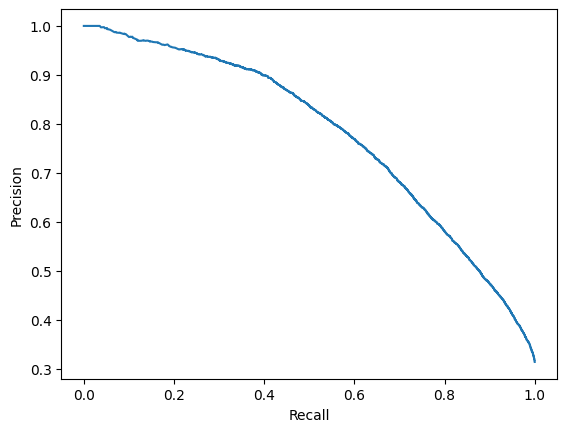

In [15]:
p, r, t = precision_recall_curve(y, preds)
plt.plot(r, p)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

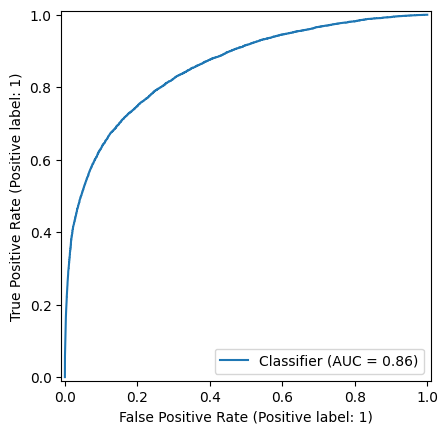

In [16]:
RocCurveDisplay.from_predictions(y, preds)
plt.show()

In [20]:
X_enc = pd.get_dummies(X, drop_first=True)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_enc)
print(pca.explained_variance_ratio_)

[0.99540428 0.00303903]


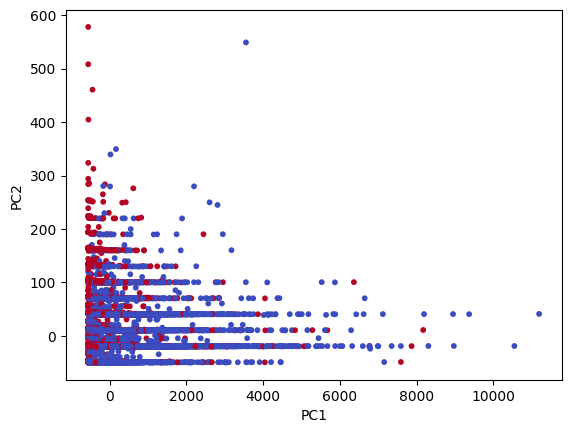

In [21]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="coolwarm", s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

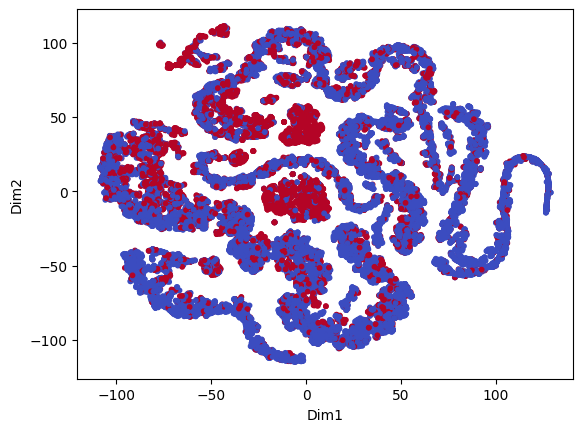

In [24]:
X_enc = pd.get_dummies(X, drop_first=True)
X_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_enc)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap="coolwarm", s=10)
plt.xlabel("Dim1")
plt.ylabel("Dim2")
plt.show()